# Multi-layer perceptron implementation

Now we are going to code a multi-layer perceptron and get it to randomly initialise weights and biases, take in some pre-processed data and give us some predictions for which classes the data falls into. Because we're not doing any training *yet*, we don't expect it to make good guesses, but we need to setup the network and the pipeline before we can train! 

An MLP with a single hidden layer might look something like this:

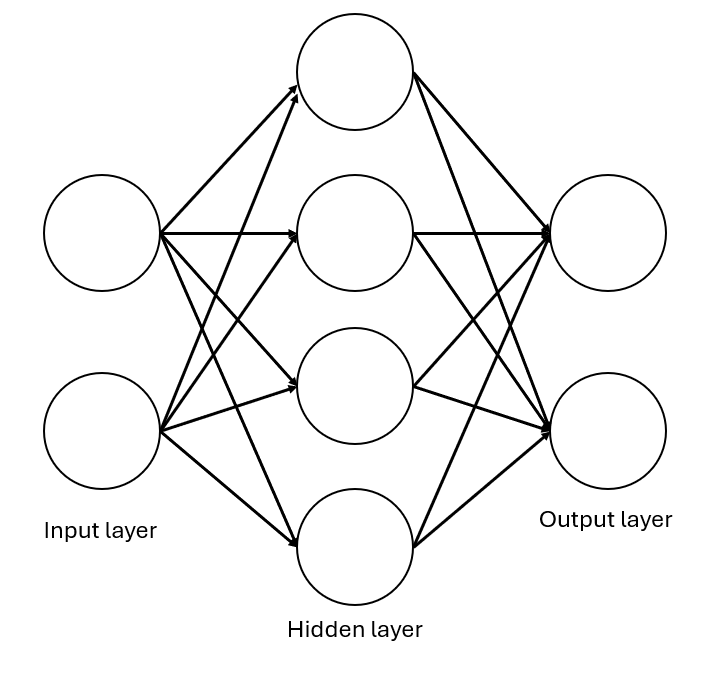

*Note*: in practise your MLP can be as deep (i.e. number of hidden layers) and as wide (i.e. number of neurons in a hidden layer) but for our purposes, a single hidden layer will be sufficient!

The three main components of an MLP are:
1. The Input layer: where each neuron represents a feature (e.g. petal length). This layer passes data forward without performing computation.
2. The Hidden layer(s): The core of the neural network. Neurons in the hidden layers:
    - Receive inputs from all previous-layer neurons (fully connected)
    - Apply a weighted sum and a non-linear activation function (like ReLU)
    - Learn by updating weights during training (using backpropogation which we'll learn about later)
3. The Output layer: Generates the prediction. For classification tasks like the Iris dataset, each neuron can represent a class (e.g. setosa, versicolor, virginica).

## Step 1: Define the MLP model

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialise a simple feedforward MLP architecture.
        
        Parameters:
         input_size: Number of input features (e.g., 4 for Iris dataset)
         hidden_size: Number of neurons in the hidden layer
         num_classes: Number of output classes (e.g., 3 for Iris species)
        """
        super(MLP, self).__init__()
        
        # First layer (input to hidden)
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
        # Second layer (hidden to hidden)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        
        # Output layer (hidden to output)
        self.output = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

        """
        Softmax is applied to the output layer to convert raw scores (logits) into probabilities.
        The dim=1 argument specifies that the softmax should be applied across the classes (columns) for each sample (row).
        E.g. softmax([a, b, c]) = [exp(a)/(exp(a)+exp(b)+exp(c)), exp(b)/(exp(a)+exp(b)+exp(c)), exp(c)/(exp(a)+exp(b)+exp(c))]
        This ensures that the output probabilities are between 0 and 1 and sum to 1 for each sample.
        It's like sigmoid but for multi-class classification.
        """
        
    def forward(self, x):
        """
        Define the forward pass through the network for a single input.
        
        Parameter:
         x: Input tensor of shape [input_size] representing a single sample
        
        Returns:
         Output tensor of shape [num_classes] for a single prediction
        """

        # Forward pass through the network
        # Each step applies a linear transformation followed by a non-linear activation
        
        x = self.layer1(x)
        x = self.relu(x)
            
        x = self.layer2(x)
        x = self.relu(x)
            
        x = self.output(x)
        x = self.softmax(x)  # Apply softmax to get probabilities
        
        return x

## Step 2: Set model parameters and initialise model

In [ ]:
input_size = 4    # Assuming 4 features (like Iris dataset)
hidden_size = 16  # Neurons in hidden layer
num_classes = 3   # Output classes 
model = MLP(input_size, hidden_size, num_classes)
model

# Insert picture here

## Step 3: Prepare Iris Test Dataset

In [ ]:
# In this step, the process is identical to the data handling steps in "DataPipeline" notebook.
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# load the dataset
iris = load_iris()
# extract features and target classes
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardise the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

batch_size = 30
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print(X)
print(y)

## Step 4: Evaluate Test Loss and Accuracy


In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialize a list to store the individual losses
losses = []

# Evaluate the average MSE loss of the model on the test_dataset
model.eval()
total_test_loss = 0
num_test_samples = 0

with torch.no_grad():
    for features, labels in test_loader:
        for i in range(features.size(0)):
            # Extract individual feature and label

            # The unsqueeze(0) adds a batch dimension to the one-hot encoded label, 
            # making it compatible with the model's output shape.

            single_feature = features[i].unsqueeze(0)  # Add batch dimension
            single_label = labels[i]

            # Forward pass
            prediction = model(single_feature)

            # The one-hot encoding converts the class label into a vector with only 0s and 1s.
            # For example, if the class label is 1 for the second class in a 3-class problem,
            # the one-hot encoding would be [0, 1, 0].

            # One-hot encode label and convert to float
            one_hot_label = F.one_hot(single_label, num_classes=3).float().unsqueeze(0)

            # Calculate MSE loss
            loss = F.mse_loss(prediction, one_hot_label)

            losses.append(loss.item())
            total_test_loss += loss.item()
            num_test_samples += 1

# Calculate average loss across all processed samples
if num_test_samples > 0:
    avg_test_loss = total_test_loss / num_test_samples
    print(f"\nAverage MSE loss on test set ({num_test_samples} samples): {avg_test_loss:.4f}")

    # Plot the losses as a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_test_samples), losses, label='Sample-wise MSE Loss', color='tab:blue', linewidth=2)
    plt.xlabel("Sample Index")
    plt.ylabel("MSE Loss")
    plt.title("MSE Loss per Sample on Test Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Two things worth noting here!

1. It should not surprise us that the MSE is generally bad and that it doesn't get any better. Each time we initialise our MLP, its with random weights and biases, so we expect the MSE to be somewhat sporadic.
2. Given that there are 3 classes of equal sizes, we expect on average to get about $33%$ of the guesses right which is why our MSE has values around 0.2 to 0.3.